In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
sys.path.append('../core/')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import cartopy.crs as ccrs
from scipy.interpolate import RegularGridInterpolator, InterpolatedUnivariateSpline, UnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
import healpy as hp
from settings import *

from tqdm import tqdm, trange, tqdm_notebook
fs = 20
fs_ticks = 16

import healpy as hp
from matplotlib.lines import Line2D
from copy import deepcopy

from tools import *
from tools import _trans

In [3]:
# define location of experiments
poles = {
    'IceCube': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "tab:orange"},
    'Gen-2': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "magenta"},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg, "color": "tab:blue"},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg, "color": "k"},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg, "color": "tab:cyan"},
    'Plenum': {"color": "darkred"}
}

### testing cartopy 😻

In [4]:
print("\U0001F63B")

😻


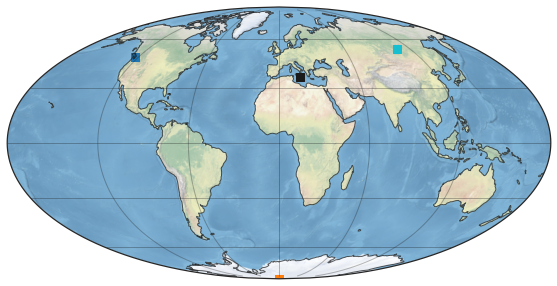

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=ccrs.Mollweide())
ax.set_global()
ax.stock_img()
ax.coastlines(color="k", alpha=0.7)
gl = ax.gridlines(draw_labels=False, alpha=0.3, color="k", ls=":")


for i, (name, new_pole) in enumerate(sorted(poles.items())):
    if name=="Plenum": continue
    ax.scatter(
        np.degrees(new_pole["lon"]), np.degrees(new_pole["lat"]),
        s=70, alpha=1,
        marker='s', c=new_pole["color"], 
        linestyle='None', 
        label=name,
        transform=ccrs.PlateCarree()
    )

In [6]:
# add fermi sources on top 
_3FHL = np.load('../resources/3FHL_All_2019.npy')
_4FGL = np.load('../resources/4FGL.npy')

In [7]:
tracks = np.load('../resources/tracks.npy')

ang_unc = np.empty(len(tracks), dtype=float)
for i, ra_err in enumerate(tracks['ra_err']):
    name = tracks['name'][i]
    if b'HES' in name and not b'AHES' in name:
        ang_unc[i] = ra_err[0]
    else:
        Dec_err = np.mean([tracks['dec_err'][i][0], -tracks['dec_err'][i][1]])
        Ra_err = np.mean([ra_err[0], -ra_err[1]])
        ang_unc[i] = conv2ang_uncertainty(Ra_err,Dec_err, tracks['dec'][i])

        
tracks = np.lib.recfunctions.append_fields(tracks, names='sigma', data=ang_unc,
                                        dtypes=float, usemask=False)

### First, get all effective areas

In [8]:
with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * np.sum(ra_width) # = 2pi

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
print(len(ra_mids), "RA bins")

40 log_10(energy) bins
50 declination bins
100 RA bins


In [9]:
# GEN-2 will have 7.5x effective area ==> 5times better discovery potential
aeff_2d["Gen-2"] = aeff_2d["IceCube"] * 5 ** (1 / 0.8)

# Create a skymap including the ps detection efficiency and all HE tracks 

### only upgoing

### detection efficiency -- IceCube only

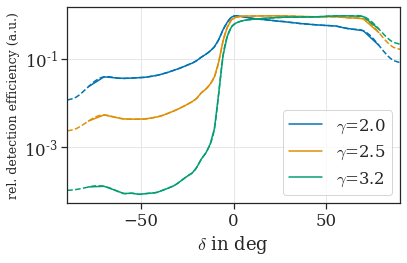

In [10]:
sindec_vals = np.linspace(-1, 1, 1000)
gammas = [2.0, 2.5, 3.2]
fig, ax = plt.subplots()
for gamma in gammas:
    Res = np.sum(aeff_eval_e_sd(aeff_2d["IceCube"]) * emids**(-gamma), axis=-1) / sindec_width
    Res_max = np.max(Res)
    Res /= np.max(Res)
    tck = InterpolatedUnivariateSpline(sindec_mids, np.log(Res))
    spl_val = np.exp(tck(sindec_vals))
    p = ax.plot(np.rad2deg(np.arcsin(sindec_mids)), Res, label=r'$\gamma$={0:.1f}'.format(gamma))
    ax.plot(np.rad2deg(np.arcsin(sindec_vals)), spl_val, ls='dashed', color=p[0].get_color())
    
ax.legend(loc=0)
ax.set_xlabel(r'$\delta$ in deg ')
ax.set_ylabel(r'rel. detection efficiency (a.u.)', fontsize="x-small")
ax.set_yscale('log')
ax.set_xlim(-90, 90)
fig.tight_layout()

### all detectors -- detection efficiency 1D (sin dec) relative to icecube at horizon

In [11]:
tcks = dict()
tcks_raw = dict()
for ii, gamma in enumerate(np.round(np.arange(1.4, 3.6, step=0.1), decimals=1)):
    tcks[gamma] = dict()
    tcks_raw[gamma] = dict()
    for det in aeff_2d:
        Res = np.sum(aeff_eval_e_sd(aeff_2d[det]) * emids**(-gamma), axis=-1) / sindec_width
        tcks[gamma][det] = InterpolatedUnivariateSpline(sindec_mids, np.log(Res))
        tcks_raw[gamma][det] = np.copy(Res)
        

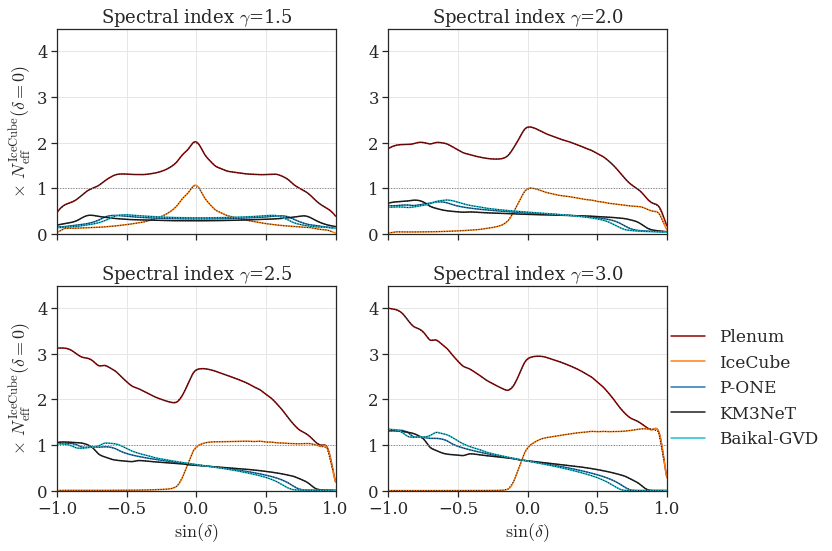

In [12]:
gammas = [1.5, 2.0, 2.5, 3.]
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    #sharey=True,
    sharex=True, figsize=(12, 8))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # detection efficiency of IceCube for specific spectral index at the horizon
    ## NOTE: maximum detection efficiency changes with spectral index, so we fix this to the horizon here
    # OPEN FOR DISCUSSION ...
    arb_max_ic = tcks_raw[gamma]["IceCube"][len(sindec_mids)//2]
    for det in aeff_2d:
        if det=="Gen-2": continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / arb_max_ic
        Res_raw = np.copy(tcks_raw[gamma][det]) / arb_max_ic
        p = ax.plot(sindec_vals, Res, label=det, color=poles[det]["color"])
        p = ax.plot(sindec_mids, Res_raw, color="k", ls=":", lw=1)
    ax.set_title(r'Spectral index $\gamma$={0:.1f}'.format(gamma))
    #ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 4.5)
    ax.axhline(1, color="gray", ls=":", lw=1)
    
axes[2].set_xlabel(r'$\sin(\delta)$')
axes[3].set_xlabel(r'$\sin(\delta)$')
axes[0].set_ylabel(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta=0)$')
axes[2].set_ylabel(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta=0)$')
ax.legend(
    fontsize=fs-3, loc='center',
    ncol=1, frameon=False, bbox_to_anchor=(1.28, 0.5)
)
fig.tight_layout()

### all detectors -- detection efficiency relative to icecube at respective declination

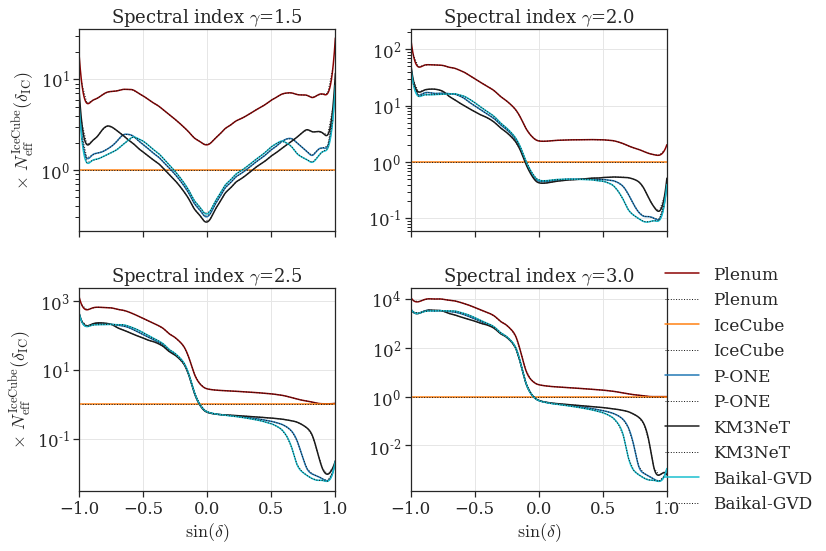

In [13]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(
    nrows=2, ncols=2, 
    #sharey=True, 
    sharex=True,
    figsize=(12, 8)
)
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # detection efficiency of IceCube for specific spectral index at the horizon
    ## NOTE: maximum detection efficiency changes with spectral index, so we fix this to the horizon here
    # OPEN FOR DISCUSSION ...
    for det in aeff_2d:
        if det=="Gen-2": continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(tcks[gamma]["IceCube"](sindec_vals))
        Res_raw = tcks_raw[gamma][det] / tcks_raw[gamma]["IceCube"]
        p = ax.plot(sindec_vals, Res, label=det, color=poles[det]["color"])
        p = ax.plot(sindec_mids, Res_raw, label=det, color="k", ls=":", lw=1)
    ax.set_title(r'Spectral index $\gamma$={0:.1f}'.format(gamma))
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    #ax.set_ylim(1e-2, 1.2e4)
    
axes[2].set_xlabel(r'$\sin(\delta)$')
axes[3].set_xlabel(r'$\sin(\delta)$')
axes[0].set_ylabel(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta_{\rm IC})$')
axes[2].set_ylabel(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta_{\rm IC})$')
ax.legend(
    fontsize=fs-3, loc='center',
    ncol=1, frameon=False, bbox_to_anchor=(1.28, 0.5)
)
fig.tight_layout()

# Get the detection efficiency from each telescope for one time stamp

In [14]:
num = 500
ra_vals = np.linspace(0, 2*np.pi, num)
ra_val_mids = calc_mids(ra_vals)
ra_val_width = np.diff(ra_vals)
dec_vals = np.linspace(-np.pi/2, np.pi/2, num)
dec_val_mids = calc_mids(dec_vals)

In [15]:
inst_rel_events_ra_dec = {}
rel_events_ra_dec = {}
for ii, gamma in tqdm(enumerate(np.round(np.arange(1.4, 3.6, step=0.1), decimals=1))):
    inst_rel_events_ra_dec[gamma] = {}
    rel_events_ra_dec[gamma] = {}

    aeff_tmp = np.sum(
        aeff_eval_e_sd(aeff_2d["IceCube"]) * emids**(-gamma),
        axis=-1) / sindec_width
    aeff_tmp /= aeff_tmp[len(sindec_mids)//2]
    aeff_tmp = aeff_tmp[::-1,np.newaxis] * np.ones_like(
        np.atleast_2d(ra_vals)) #/ np.atleast_2d(ra_val_width) / len(ra_val_mids)
    
    # pad with zeros to have full declination coverage without nasty boundary issues
    shape = np.shape(aeff_tmp)
    padded_array = np.zeros(np.array(shape) + [2, 0])
    padded_array[1:shape[0]+1,:shape[1]] = aeff_tmp
    padded_dec = np.concatenate([[-np.pi/2], np.arcsin(sindec_mids), [np.pi/2]])
    padded_array[0] = padded_array[1]
    padded_array[-1] = padded_array[-2]
    
    grid2d = RegularGridInterpolator(
        (padded_dec, ra_vals),
        padded_array,
        method='linear',
        bounds_error=False,
        fill_value=None
    )
    # grid elements are calculated for each energy bin, grid is theta x phi
    # coordinate grid in equatorial coordinates (icrs)
    # these will be the integration coordinates
    pp, tt = np.meshgrid(ra_vals, dec_vals)
    eq_grid = SkyCoord(
        pp * u.radian,
        tt * u.radian,
        frame="icrs"
    )
    # loop over detectors
    inst_rel_events_ra_dec[gamma]["Plenum"] = np.zeros_like(pp)
    rel_events_ra_dec[gamma]["Plenum"] = np.zeros_like(pp)
    for k, coord in poles.items():
        if k=="Plenum": continue
        # local detector
        loc = EarthLocation(lat=coord["lat"], lon=coord["lon"])
        # arbitrary time, doesnt matter here
        time = Time('2020-2-20 00:00:00')
        # transform integration coordinates to local frame
        local_coords_grid = eq_grid.transform_to(AltAz(obstime=time, location=loc))
        inst_rel_events_ra_dec[gamma][k] = grid2d(
            (local_coords_grid.alt.rad, local_coords_grid.az.rad))
        # average over right ascension
        rel_events_ra_dec[gamma][k] = np.sum(inst_rel_events_ra_dec[gamma][k] / len(ra_val_mids), axis=1)
        rel_events_ra_dec[gamma][k] = rel_events_ra_dec[gamma][k][:,np.newaxis] * np.ones_like(np.atleast_2d(ra_vals))
        
        # do not add gen2 to plenum for now
        if  k!="Gen-2": 
            inst_rel_events_ra_dec[gamma]["Plenum"] += inst_rel_events_ra_dec[gamma][k]
            rel_events_ra_dec[gamma]["Plenum"] += rel_events_ra_dec[gamma][k]
        else:
            # 5 times larger effective area for Gen2
            inst_rel_events_ra_dec[gamma][k] *= 5
            rel_events_ra_dec[gamma][k] *= 5
print("Done")

with open("../resources/rel_events_ra_dec.pckl", "wb") as f:
    pickle.dump(rel_events_ra_dec, f)
    
with open("../resources/inst_rel_events_ra_dec.pckl", "wb") as f:
    pickle.dump(inst_rel_events_ra_dec, f)

22it [00:19,  1.10it/s]


Done


In [16]:
with open("../resources/rel_events_ra_dec.pckl", "rb") as f:
    rel_events_ra_dec = pickle.load(f)
    
with open("../resources/inst_rel_events_ra_dec.pckl", "rb") as f:
    inst_rel_events_ra_dec = pickle.load(f)

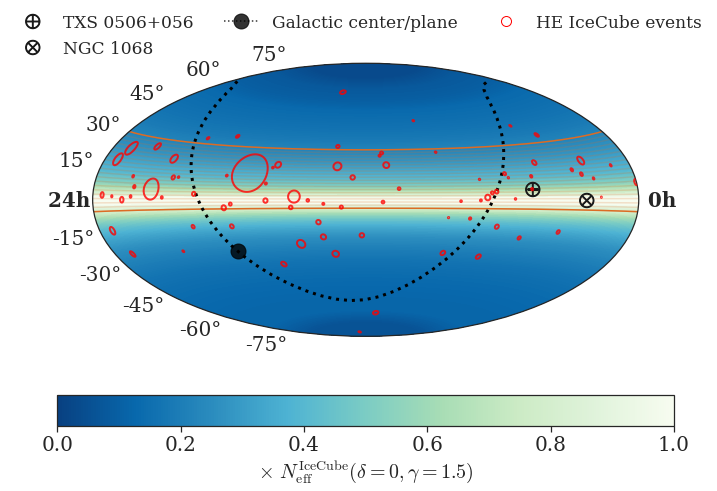

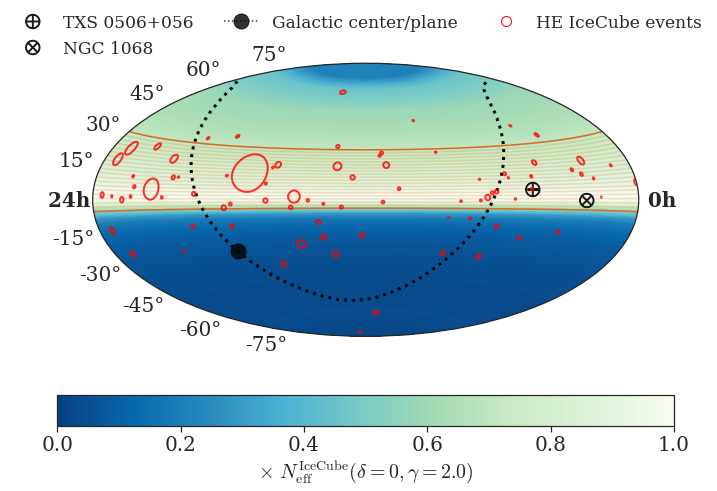

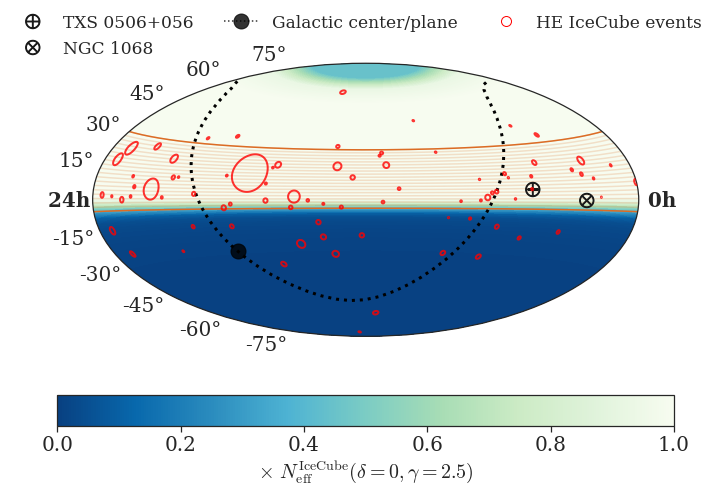

In [17]:
for gamma in [1.5, 2.0, 2.5]:
    fig = plt.figure(figsize=(10,7.))
    ax = fig.add_subplot(111, projection='hammer', rasterized=True)
    cax = ax.pcolormesh(
        ra_vals-np.pi, dec_vals, rel_events_ra_dec[gamma]["IceCube"], vmin=0, vmax=1, cmap='GnBu_r')
    cbar = fig.colorbar(cax, orientation='horizontal')
    cbar.set_label(
        fr'$\times$ $N_{{\rm eff}}^{{\rm IceCube}}(\delta=0, \gamma={gamma})$', 
        fontsize=fs
    )
    cbar.ax.tick_params(labelsize=fs)

    #---------------------------------------
    # show the IceCube lines between -5 and 30 deg
    #---------------------------------------
    c = '#DC6C25'
    y1 = np.tile(np.radians(-5.), num)
    y2 = np.tile(np.radians(30), num)

    _x, _y1 =  _trans(ra_vals, y1)
    _x, _y2 =  _trans(ra_vals, y2)
    ind = np.argsort(_x)
    ax.plot(_x[ind], _y1[ind], color=c)
    ax.plot(_x[ind], _y2[ind], color=c)

    for y_i in np.linspace(-5, 30,num=20, endpoint=True): 
        ytmp = np.tile(y_i ,len(ra_vals))
        _x2, _y2 = _trans(ra_vals, np.radians(ytmp))
        ind = np.argsort(_x2)
        ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

    #loc1, loc2 = _trans(0, -np.pi/2)
    #ax.plot(loc1, loc2, marker='s', c=c, linestyle='None')

    #  add also TXS and NGC1068
    add_obj(ax, "txs", marker=r'$\bigoplus$', c='k') #DC6C25
    add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k') #DC6C25


    # add event with error radius
    for i, (rai, deci, si) in enumerate(zip(tracks['ra'], tracks['dec'], tracks['sigma'])):
        c='red'
        if i == 0:
            res = add_event(
                ax, ra_i=np.radians(rai), dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                labels=['IceCube HE events'], color=c, linewidths=2., zorder=10
            )
        else:
            add_event(
                ax, ra_i=np.radians(rai), dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                color=c, linewidths=2.,zorder=10
            )

    # fix the labels
    set_ticks(ax, fs=fs)
    # add the galactic center and plane
    add_plane(ax, color='black')

    #get all legend entries and add the circle for the HE events
    handles, labels = ax.get_legend_handles_labels()
    HE_events = Line2D(
        range(1), range(1), color="red", 
        marker='o', markersize=10, markerfacecolor="None",
        linewidth=0, label='HE IceCube events'
    )
    handles.append(HE_events)
    fig.legend(
        handles=handles, fontsize=fs-3,
        #loc=0, 
        mode='expand',
        ncol=3, frameon=False
    )

    fig.tight_layout()
    plt.subplots_adjust(top = 0.87) #, bottom=0.2)
    fig.savefig(
        f'../plots/IceCube_Skymap_horizon_gamma{int(np.round(gamma*10))}.pdf',
        bbox_inches="tight", dpi=200)
    plt.show()

# Show a skymap with 4 time snippets of the cumulative view of the best field 
# of view of all existing telescopes

### IceCube only, all day, every day 

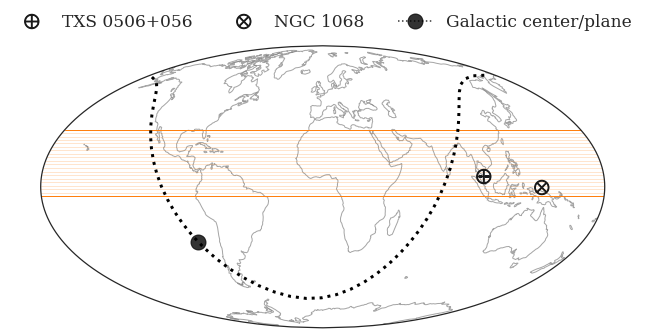

In [18]:
f, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.Mollweide())) #ccrs.Mollweide()
ax.set_global()
ax.coastlines(color="gray", alpha=0.7)

ax.plot(np.rad2deg(ra_vals), np.rad2deg(y1), color=poles["IceCube"]["color"], transform=ccrs.PlateCarree(), lw=1)
ax.plot(np.rad2deg(ra_vals), np.rad2deg(y2), color=poles["IceCube"]["color"], transform=ccrs.PlateCarree(), lw=1)

for y_i in np.linspace(-5, 30, num=20, endpoint=True):
    y_loc = np.tile(y_i, len(ra_vals))
    ax.plot(np.rad2deg(ra_vals), y_loc, color=poles["IceCube"]["color"], alpha=0.2, transform=ccrs.PlateCarree(), lw=1)
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', transform=ccrs.PlateCarree()) #DC6C25
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', transform=ccrs.PlateCarree()) #DC6C25
add_plane(ax, color='black', transform=ccrs.PlateCarree())
ax.legend(
    fontsize=fs-3, loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.)
)
f.tight_layout()

IceCube
P-ONE
KM3NeT
Baikal-GVD


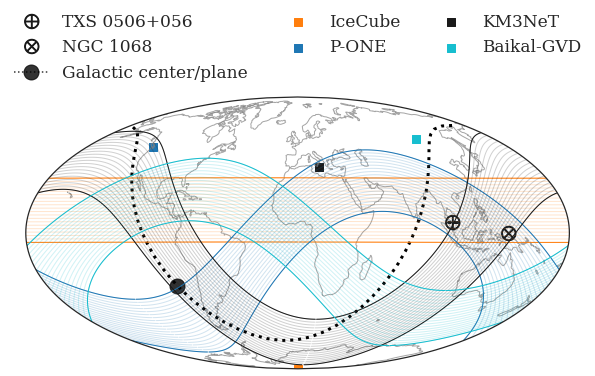

IceCube
P-ONE
KM3NeT
Baikal-GVD


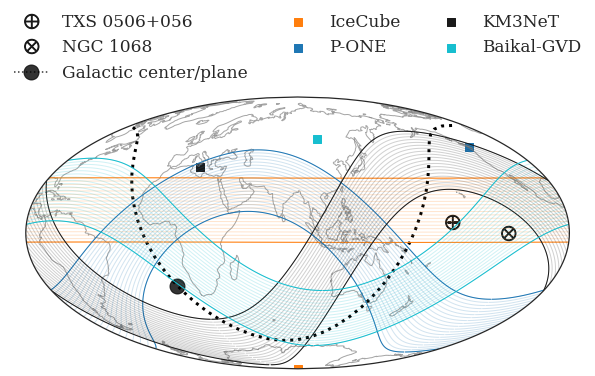

IceCube
P-ONE
KM3NeT
Baikal-GVD


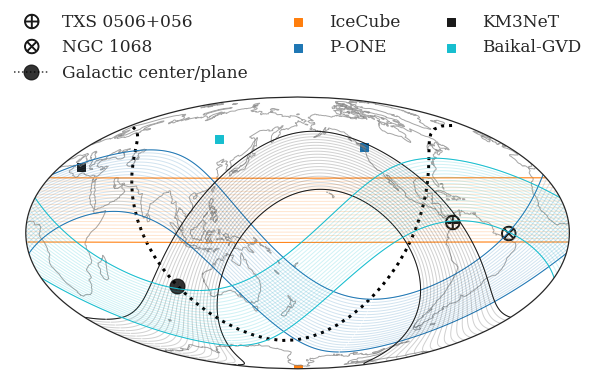

IceCube
P-ONE
KM3NeT
Baikal-GVD


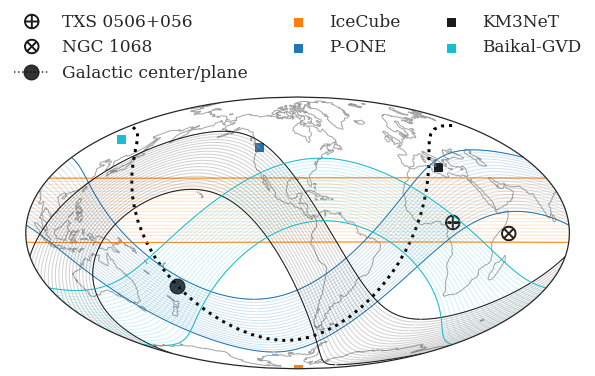

In [19]:
# loop through daily rotations
for clon in [0, 90, 180, 270]:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
    ax.set_global()
    ax.coastlines(color="gray", alpha=0.7)

    # coordinate grid in equatorial coordinates (icrs)
    # these will be the integration coordinates
    eq_coords_low = SkyCoord(
        ra_vals * u.radian,
        -y1 * u.radian,
        frame="icrs"
    )
    eq_coords_up = SkyCoord(
        ra_vals * u.radian,
        -y2 * u.radian,
        frame="icrs"
    )

    ic_loc = EarthLocation(
        lat=poles["IceCube"]["lat"],
        lon=poles["IceCube"]["lon"],
    )

    add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', transform=ccrs.PlateCarree(central_longitude=clon)) #DC6C25
    add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', transform=ccrs.PlateCarree(central_longitude=clon)) #DC6C25
    add_plane(ax, color='black', transform=ccrs.PlateCarree(central_longitude=clon))

    # loop over detectors
    for i, (k, coord) in enumerate(poles.items()):
        if k=="Plenum" or k=="Gen-2": continue
        print(k)
        # local detector
        loc = EarthLocation(
            lat=coord["lat"],
            lon=coord["lon"],
        )
        time = Time('2021-4-20 00:00:00', scale="utc")
        # transform integration coordinates to local frame
        local_coords_low = eq_coords_low.transform_to(AltAz(obstime=time, location=loc))
        local_coords_up = eq_coords_up.transform_to(AltAz(obstime=time, location=loc))
        
        ind = np.argsort(local_coords_low.az.deg)
        ax.plot(local_coords_low.az.deg[ind] + loc.lon.deg, local_coords_low.alt.deg[ind], transform=ccrs.PlateCarree(), lw=1, color=coord["color"])
        ax.plot(local_coords_up.az.deg[ind] + loc.lon.deg, local_coords_up.alt.deg[ind], transform=ccrs.PlateCarree(), lw=1, color=coord["color"])
        ax.scatter(loc.lon.deg, loc.lat.deg, color=coord["color"], marker="s", s=50, transform=ccrs.PlateCarree(), label=k)

        for y_i in np.linspace(-30, 5, num=20, endpoint=True):
            y_loc = np.tile(y_i, len(ra_vals))
            local_coords_tmp = SkyCoord(
                ra_vals * u.radian, y_loc * u.degree, frame="icrs"
            ).transform_to(AltAz(obstime=time, location=loc))
            ind = np.argsort(local_coords_tmp.az.deg)
            ax.plot(
                local_coords_tmp.az[ind].deg + loc.lon.deg, 
                local_coords_tmp.alt.deg[ind], 
                transform=ccrs.PlateCarree(), 
                lw=1, color=coord["color"], 
                alpha=0.2
            )
        ax.legend(
            fontsize=fs-3, loc='lower center',
            ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.)
        )
        f.tight_layout()
    plt.show()

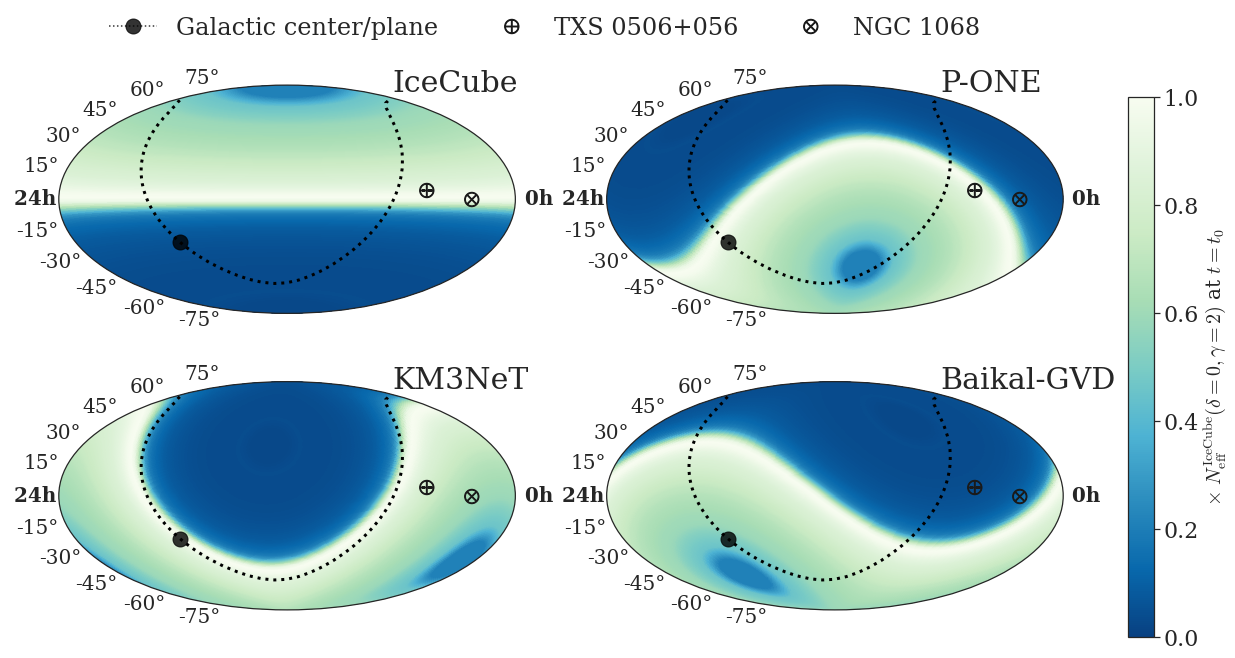

In [20]:
fig =  plt.figure(figsize=(18, 10))
n2ind = {'IceCube':221, 'P-ONE':222, 'KM3NeT':223, 'Baikal-GVD':224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if name=="Plenum" or name=="Gen-2": continue
    ax = fig.add_subplot(n2ind[name], projection='hammer', rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap='GnBu_r')
    
    ## 3FHL 
    #sett = dict(n=100,  marker='o', color='tab:cyan', s=15, alpha=0.8, vals=None)
    #add_catalog(
    #    ax, cat=_3FHL, label='3FHL sources' if i==0 else '__None__',
    #    **sett)
    ## 4FGL
    #sett.update(dict(color='tab:orange', marker="s"))
    #add_catalog(
    #    ax, cat=_4FGL, label='4FGL sources' if i==0 else '__None__',
    #    **sett)
    # fix the labels
    set_ticks(ax, fs=fs)
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
        make_legend = False
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(0.73, 0.97, name, fontsize=30, transform = ax.transAxes)

fig.legend(
    fontsize=fs+4, loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.9))
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta=0, \gamma=2)$ at $t=t_0$', fontsize=fs)
cbar.ax.tick_params(labelsize=fs+2)
#plt.subplots_adjust(top = 0.9, right=0.9, wspace=0.15)
fig.savefig('../plots/skymaps_local_time.pdf', bbox_inches="tight")

## time integrated

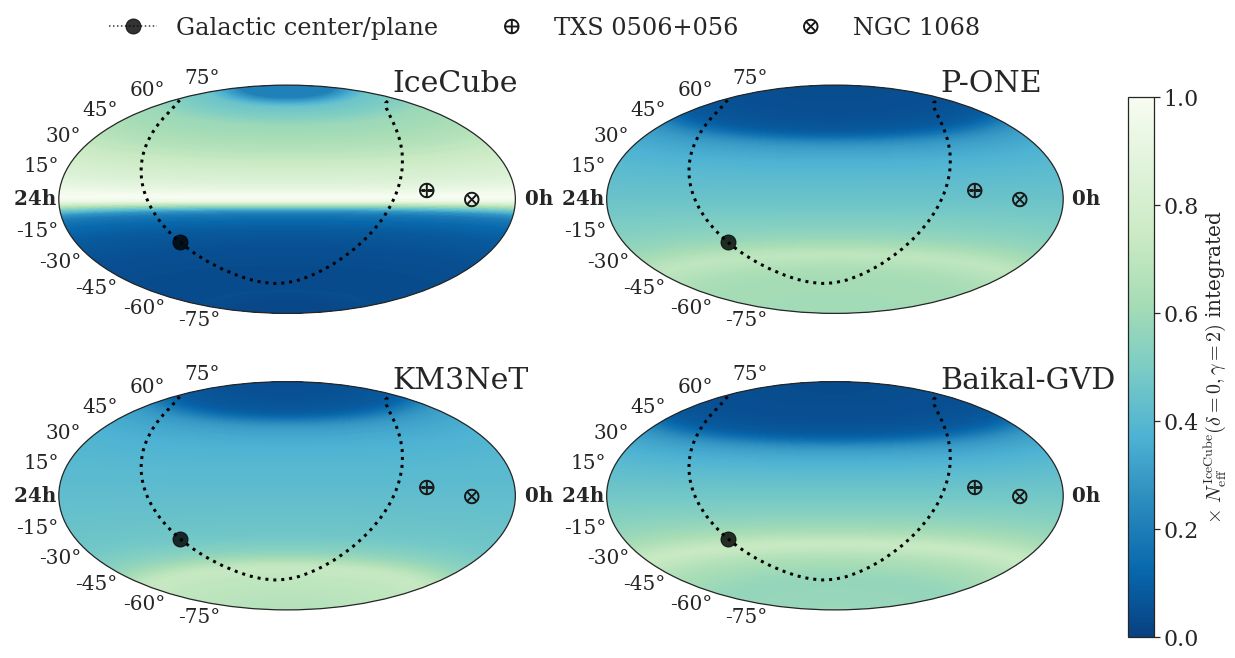

In [21]:
fig =  plt.figure(figsize=(18, 10))
n2ind = {'IceCube':221, 'P-ONE':222, 'KM3NeT':223, 'Baikal-GVD':224}
gamma = 2.0
make_legend = True

for i, (name, vals) in enumerate(rel_events_ra_dec[gamma].items()):
    if name=="Plenum" or name=="Gen-2": continue
    ax = fig.add_subplot(n2ind[name], projection='hammer', rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap='GnBu_r')
    
    ## 3FHL 
    #sett = dict(n=100,  marker='o', color='tab:cyan', s=15, alpha=0.8, vals=None)
    #add_catalog(
    #    ax, cat=_3FHL, label='3FHL sources' if i==0 else '__None__',
    #    **sett)
    ## 4FGL
    #sett.update(dict(color='tab:orange', marker="s"))
    #add_catalog(
    #    ax, cat=_4FGL, label='4FGL sources' if i==0 else '__None__',
    #    **sett)
    # fix the labels
    set_ticks(ax, fs=fs)
    # add the galactic center and plane

    if make_legend:
        make_legend = False
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(0.73, 0.97, name, fontsize=30, transform = ax.transAxes)

fig.legend(
    fontsize=fs+4, loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.9))
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(r'$\times$ $N_{\mathrm{eff}}^{\mathrm{IceCube}}(\delta=0, \gamma=2)$ integrated', fontsize=fs)
cbar.ax.tick_params(labelsize=fs+2)
#plt.subplots_adjust(top = 0.9, right=0.9, wspace=0.15)
fig.savefig('../plots/skymaps_time_integrated.pdf', bbox_inches="tight")

# Plenum improvements for gamma=2 and the same amount of time

This plot shows a direct comparison of plenum and IceCube for equal run times

### Idea:
* Discovery potential improvement:

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at horizon $(\delta=0)$:

$R_0 = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta=0) \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at resp. declination:

$R_{rel} = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta) \cdot d\Phi/dE} \right)^{0.8}$

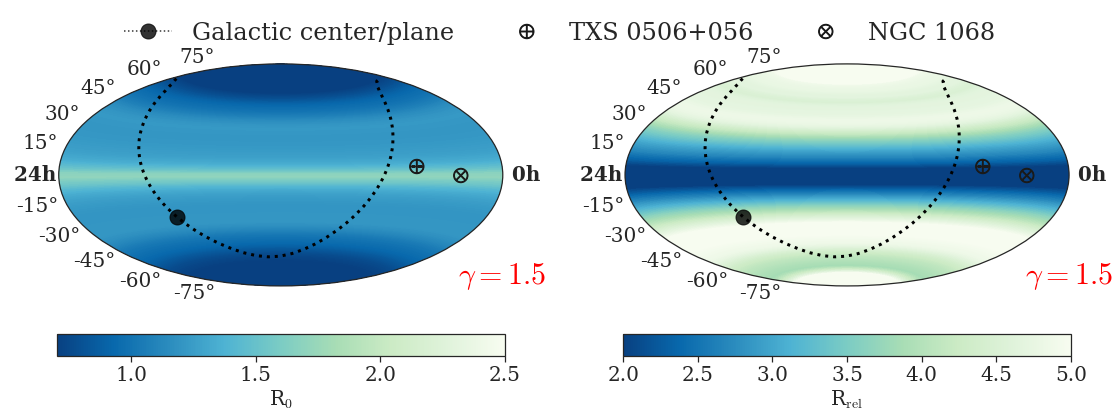

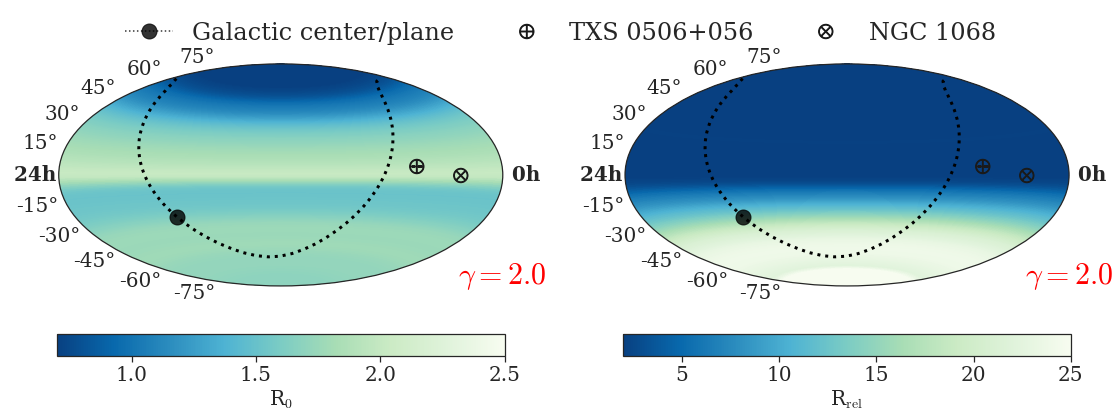

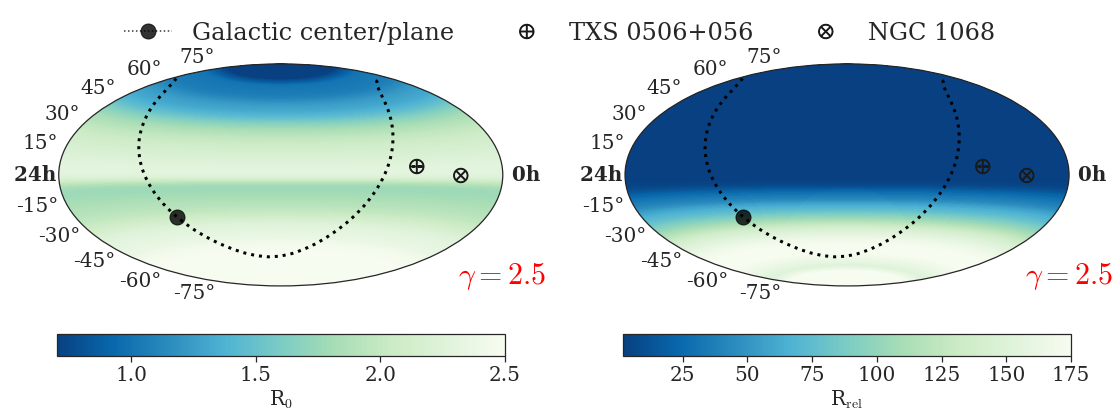

In [22]:
i2ind = {0:121, 1:122}
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {
    1.5: {'r0': (0.7, 2.5), 'rrel':(2., 5.)},
    2.0: {'r0': (0.7, 2.5), 'rrel':(2., 25.)},
    2.5: {'r0': (0.7, 2.5), 'rrel':(2., 175.)},
}

for gamma in [1.5, 2.0, 2.5]:
    fig =  plt.figure(figsize=(16, 6))
    for i, vari in enumerate(variation):
        ax = fig.add_subplot(i2ind[i], projection='hammer', rasterized=True)
        comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
        
        if vari == 'rrel':
            mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
            comb_vals[mask] = (rel_events_ra_dec[gamma]["Plenum"][mask] \
                               / rel_events_ra_dec[gamma]["IceCube"][mask]) ** 0.8
        else:
            comb_vals = (rel_events_ra_dec[gamma]["Plenum"] \
                         / rel_events_ra_dec[gamma]["IceCube"][len(rel_events_ra_dec[gamma]["IceCube"]) // 2]) ** 0.8
        _min, _max = extreme[gamma][vari]

        cax = ax.pcolormesh(
            ra_vals - np.pi, dec_vals, 
            comb_vals, 
            vmin=_min, vmax=_max,
            cmap='GnBu_r')

        cbar = fig.colorbar(cax,  orientation='horizontal')
        cbar.ax.tick_params(labelsize=fs)
        cbar.set_label(labels[vari], fontsize=fs)
        set_ticks(ax, fs=fs)
        # add the galactic center and plane
        if i==0:
            add_plane(ax, color='black')
            add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
            add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
        else:
            add_plane(ax, color='black', label='__None__')
            add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
            add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
        ax.text(
            .9, .01, fr"$\gamma={gamma}$", 
            ha='left', size=fs+10, transform=ax.transAxes, color='red')

    fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False)#,  mode='expand')
    fig.tight_layout()
    plt.subplots_adjust(top = 0.84)#, bottom=0.2)
    # fig.savefig('plots/Plenum_g3_2.png', bbox_inches="tight", dpi=200)

----

# Show the time evolution of plenum

----

This plot will show how plenum improves (after x years) the total discovery potential if we turn it on after 10years of IceCube 

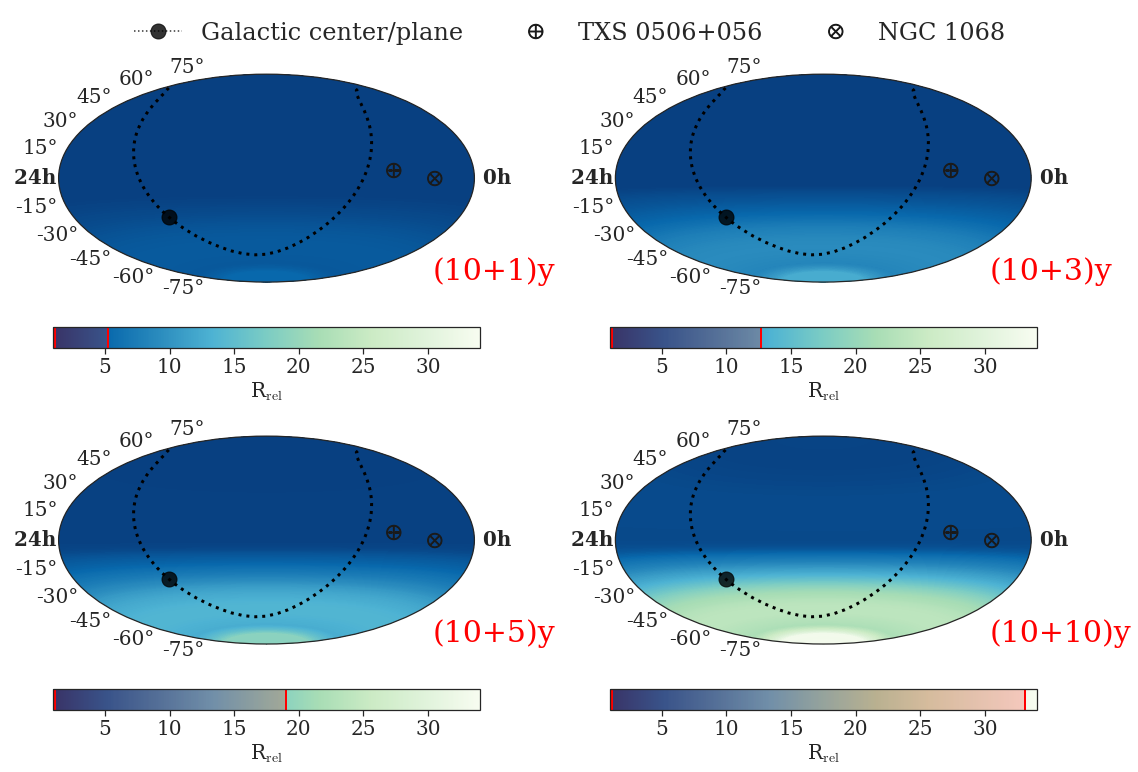

In [23]:
i2ind = { 0:221, 1:222, 2:223, 3:224 }
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {
    1.:  (1., 34.),
    3.:  (1., 34.),
    5.:  (1., 34.),
    10.: (1., 34.)
}
t_0 = 10. # years
t_news = [1., 3., 5., 10.] # years
gamma = 2.0
fig =  plt.figure(figsize=(16, 11))
vari = "rrel"

for i, t_new in enumerate(t_news):
    comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
    ax = fig.add_subplot(i2ind[i], projection='hammer', rasterized=True)
    
    mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
    comb_vals[mask] = (rel_events_ra_dec[gamma]["Plenum"][mask] \
                       / rel_events_ra_dec[gamma]["IceCube"][mask] \
                      * t_new/t_0) ** 0.8
    _min, _max = extreme[t_new]
    cax = ax.pcolormesh(
        ra_vals - np.pi, dec_vals,
        comb_vals, 
        vmin=_min, vmax=_max,
        cmap='GnBu_r'
    )
    cbar = fig.colorbar(cax,  orientation='horizontal')
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(labels[vari], fontsize=fs)
    
    cmarker_0 = _min + 0.005*(_max - _min)
    cmarker_1 = np.max(comb_vals)
    cbar.ax.axvline(cmarker_0, color='red', lw=2)
    cbar.ax.axvline(cmarker_1, color='red', lw=2)
    # I have no idea how fill_between works for color axes :D
    cbar.ax.fill_between([cmarker_0, cmarker_1], [-1, -1],[50, 50], color='red', alpha=0.2)
    
    set_ticks(ax, fs=fs)
    # add the galactic center and plane
    if i==0:
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(
        .9, .01, r"({1:d}+{0:d})y".format(int(t_new), int(t_0)), 
        ha='left', size=fs+10, transform=ax.transAxes, color='red')

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False)#,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top = 0.9)#, bottom=0.2)
# fig.savefig('plots/Plenum_g3_2.png', bbox_inches="tight", dpi=200)

# Similar plot but now also include Gen2

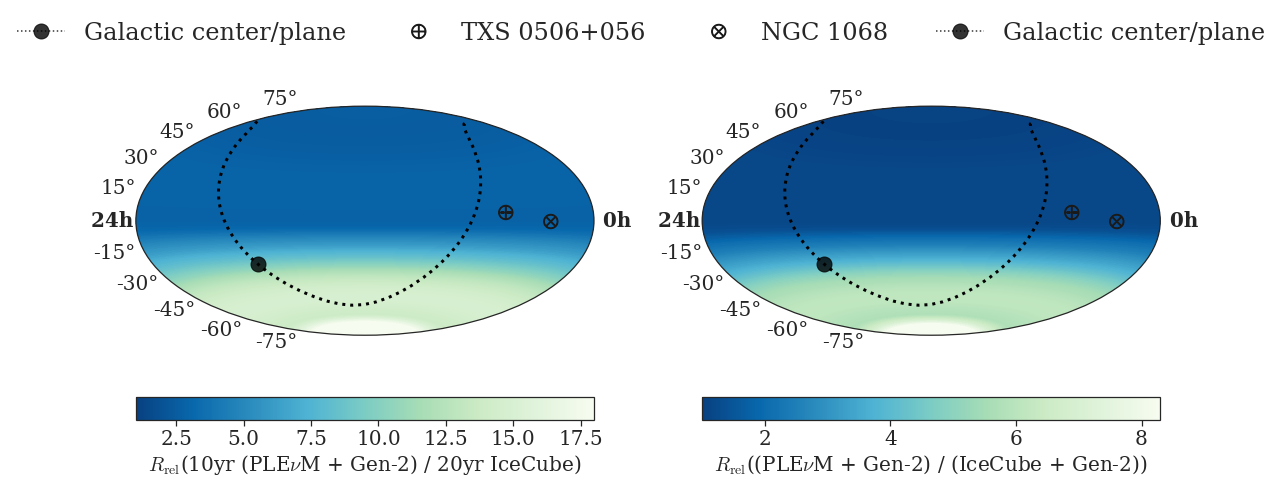

In [24]:
gamma = 2.0
fig =  plt.figure(figsize=(16, 7))
vari = "rrel"
_min, _max =  (1., 18.)

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0

ax = fig.add_subplot(121, projection='hammer', rasterized=True)
comb_vals[mask] = ((rel_events_ra_dec[gamma]["Plenum"][mask] + rel_events_ra_dec[gamma]["Gen-2"][mask]) \
                   / rel_events_ra_dec[gamma]["IceCube"][mask] \
                  * 0.5) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals,
    comb_vals, 
    vmin=_min, vmax=_max,
    cmap='GnBu_r'
)
cbar = fig.colorbar(cax,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$(10yr (PLE$\nu$M + Gen-2) / 20yr IceCube)', fontsize=fs)

set_ticks(ax, fs=fs)
# add the galactic center and plane
add_plane(ax, color='black')
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
ax = fig.add_subplot(122, projection='hammer', rasterized=True)
comb_vals[mask] = ((rel_events_ra_dec[gamma]["Plenum"][mask] + rel_events_ra_dec[gamma]["Gen-2"][mask]) \
                   / (rel_events_ra_dec[gamma]["IceCube"][mask] + rel_events_ra_dec[gamma]["Gen-2"][mask])) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals,
    comb_vals, 
    vmin=_min,# vmax=_max,
    cmap='GnBu_r'
)
cbar = fig.colorbar(cax,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$((PLE$\nu$M + Gen-2) / (IceCube + Gen-2))', fontsize=fs)

set_ticks(ax, fs=fs)
# add the galactic center and plane
add_plane(ax, color='black')
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False)#,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top = 0.9)#, bottom=0.2)
# fig.savefig('plots/Plenum_g3_2.png', bbox_inches="tight", dpi=200)

## discovery potentials of icecube -- more in point_source_discovery_time_evolution.ipynb

In [25]:
from scipy.interpolate import splev, splrep

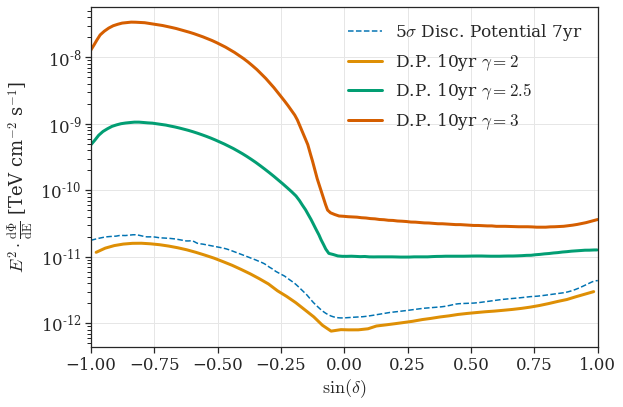

In [26]:
disc = np.genfromtxt('../resources/PSdiscPot7years.csv', delimiter=',')
sdec = disc[:,0]
disc = disc[:,1]

tck_disc = splrep(sdec, np.log(disc), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    xvals, np.exp(spl_disc),# color='red',
    ls='dashed', label="5$\sigma$ Disc. Potential 7yr")
#ax.plot(sdec, disc, alpha=0.5)
    
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2 \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)


ps_disc = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(
    ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', #color=colors[0],
    lw=3, label=r'D.P. 10yr $\gamma=2$')


ps_disc = np.genfromtxt('../resources/'+
                        '10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(
    ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', #color=colors[1],
    lw=3, label='D.P. 10yr $\gamma=2.5$')

ps_disc = np.genfromtxt('../resources/'+
                        '10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
ind_disc = np.argsort(ps_disc[:,0])
ax.plot(
    ps_disc[:,0][ind_disc], ps_disc[:,1][ind_disc], ls='solid', #color=colors[2],
    lw=3, label='D.P. 10yr $\gamma=3$')

ax.legend(
    fontsize=fs-3, loc='upper right',
    ncol=1, frameon=False,# bbox_to_anchor=(1.28, 0.5)
)
fig.tight_layout()